# Sokoban Solver

This solver uses A* algorithm to solve the puzzle:
- Use heuristic function as the sum of minimum distance from boxes to closest target (by BFS or Dijkstra's algorithm in case path costs are different)
- Using cost function `f` = `g` + `h`, where
  - `g` is a depth of the node in the tree
  - `h` is a heuristic function of the node

For visualization, the following symbols (emojis) are used:
- ⬜: Empty space
- 🟫: Wall
- 🔳: Target (a place where box msut be on)
- 🟪: Box when it is not on the target
- 🟩: Box when it is on the target
- 👦🏻: Player

The goal of this problem is to push all boxes to be on the targets.

In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageFont
import requests
from io import BytesIO
import time
from IPython import display
from pathlib import Path
import base64

In [2]:
# Node is (player_pos, boxes_pos, depth (g), h, path)
# State is (player_pos, boxes_pos)

class SokobanSolver:
    def __init__(self, board: list[str], player_pos: (int, int), boxes_pos: list[(int, int)]):
        self.board = board
        self.init_player_pos = player_pos
        self.init_boxes_pos = boxes_pos
        
        self.goals_pos = [(r, c) for r in range(len(board)) for c in range(len(board[r])) if board[r][c] == '2']
        
        self.width = len(board[0])
        self.height = len(board)
        
        self.dead_space = self.generate_dead_space_matrix()
        
        self.minimum_distance_map = dict()
        for goal_pos in self.goals_pos:
            self.minimum_distance_map[goal_pos] = self.minimum_distances(goal_pos)
        
        self.visited_states = {}
        self.fringe = []
        self.time_used = 0
        
        self.solution = None
        
        self.expanded_nodes_count = 0
        self.visited_nodes_count = 0
        
        grid_size = 50        
        wall_img_response = requests.get('https://raw.githubusercontent.com/pineylilly/pineylilly/refs/heads/main/files/ai2-sokoban-img/wall.png')
        self.wall_img = Image.open(BytesIO(wall_img_response.content)).resize((grid_size, grid_size))
        box_img_response = requests.get('https://raw.githubusercontent.com/ooxi/sokoban-ebiten-assets/refs/heads/main/pkg/assets/assets/Crate_Brown.png')
        self.box_img = Image.open(BytesIO(box_img_response.content)).resize((grid_size, grid_size))
        box_valid_img_response = requests.get('https://raw.githubusercontent.com/ooxi/sokoban-ebiten-assets/refs/heads/main/pkg/assets/assets/Crate_Blue.png')
        self.box_valid_img = Image.open(BytesIO(box_valid_img_response.content)).resize((grid_size, grid_size))
        goal_img_response = requests.get('https://raw.githubusercontent.com/ooxi/sokoban-ebiten-assets/refs/heads/main/pkg/assets/assets/EndPoint_Blue.png')
        self.goal_img = Image.open(BytesIO(goal_img_response.content)).resize((grid_size, grid_size))
        player_img_response = requests.get('https://raw.githubusercontent.com/ooxi/sokoban-ebiten-assets/refs/heads/main/pkg/assets/assets/Character5.png')
        self.player_img = Image.open(BytesIO(player_img_response.content)).resize((grid_size, grid_size))
        font_response = requests.get('https://github.com/googlefonts/roboto-2/raw/refs/heads/main/src/hinted/Roboto-Regular.ttf')
        self.font = ImageFont.truetype(BytesIO(font_response.content), 20)
        
        
        
    def is_corner(self, r: int, c: int) -> bool:
        return (self.board[r - 1][c] == '1' and self.board[r][c - 1] == '1') or (self.board[r - 1][c] == '1' and self.board[r][c + 1] == '1') or (self.board[r + 1][c] == '1' and self.board[r][c - 1] == '1') or (self.board[r + 1][c] == '1' and self.board[r][c + 1] == '1')  

        
        
    def generate_dead_space_matrix(self) -> list[list[bool]]:
        # Dead space is a position that is not reachable by any box
        # Dead space matrix is a matrix that contains dead space information
        # Dead space is marked as True
        
        dead_space = [[False for _ in range(self.width)] for _ in range(self.height)]
        
        # Check for corner without goal
        for r in range(self.height):
            for c in range(self.width):
                if dead_space[r][c]:
                    continue
                if self.board[r][c] == '1':
                    dead_space[r][c] = True
                elif self.board[r][c] == '2':
                    dead_space[r][c] = False
                elif r > 0 and c > 0 and r < self.height - 1 and c < self.width - 1 and self.is_corner(r, c) and self.board[r][c] != '2':
                    dead_space[r][c] = True
        
        # Check if block is in the edge that cannot be pushed to goal
        for r in range(self.height):
            for c in range(self.width):
                if self.board[r][c] == '1' or self.board[r][c] == '2':
                    continue
                elif dead_space[r][c]:
                    continue
                elif r > 0 and c > 0 and r < self.height - 1 and c < self.width - 1:
                    if self.board[r-1][c] == '1' or self.board[r+1][c] == '1':
                        
                        left_c = c
                        while left_c > 0 and self.board[r][left_c-1] != '1' and (self.board[r-1][left_c] == '1' or self.board[r+1][left_c] == '1') and self.board[r][left_c] != '2':
                            left_c -= 1
                        if not self.is_corner(r, left_c) or not dead_space[r][left_c]:
                            continue
                        
                        right_c = c
                        while right_c < self.width - 1 and self.board[r][right_c+1] != '1' and (self.board[r-1][right_c] == '1' or self.board[r+1][right_c] == '1') and self.board[r][right_c] != '2':
                            right_c += 1
                        if not self.is_corner(r, right_c) or not dead_space[r][right_c]:
                            continue
                        
                        for cur_c in range(left_c, right_c + 1):
                            dead_space[r][cur_c] = True
                        
                    if self.board[r][c-1] == '1' or self.board[r][c+1] == '1':
                        
                        top_r = r
                        while top_r > 0 and self.board[top_r-1][c] != '1' and (self.board[top_r][c-1] == '1' or self.board[top_r][c+1] == '1') and self.board[top_r][c] != '2':
                            top_r -= 1
                        if not self.is_corner(top_r, c) or not dead_space[top_r][c]:
                            continue
                        
                        bottom_r = r
                        while bottom_r < self.height - 1 and self.board[bottom_r+1][c] != '1' and (self.board[bottom_r][c-1] == '1' or self.board[bottom_r][c+1] == '1') and self.board[bottom_r][c] != '2':
                            bottom_r += 1
                        if not self.is_corner(bottom_r, c) or not dead_space[bottom_r][c]:
                            continue
                        
                        for cur_r in range(top_r, bottom_r + 1):
                            dead_space[cur_r][c] = True
                        
        return dead_space
        
        
    
    def minimum_distances(self, start_pos: (int, int)):
        # Shortest path from start_pos to any position in the board
        visited_pos = [[False for _ in range(self.width)] for _ in range(self.height)]
        dist = [[999999 for _ in range(self.width)] for _ in range(self.height)]
        dist[start_pos[0]][start_pos[1]] = 0
        fringe = []
        fringe.append((start_pos, 0))
        # Perform BFS
        while fringe:
            pos, d = fringe.pop(0)
            if visited_pos[pos[0]][pos[1]]:
                continue
            visited_pos[pos[0]][pos[1]] = True
            dist[pos[0]][pos[1]] = d
            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                new_pos = (pos[0] + dr, pos[1] + dc)
                if 0 <= new_pos[0] < self.height and 0 <= new_pos[1] < self.width and self.board[new_pos[0]][new_pos[1]] != '1':
                    fringe.append((new_pos, d + 1))
        
        return dist
    
    
    
    def h(self, state: ((int, int), list[(int, int)])) -> int:
        # Heuristic function
        # Sum of minimum distances from each box to the nearest goal
        h = 0
        for box_pos in state[1]:
            h += min([self.minimum_distance_map[goal_pos][box_pos[0]][box_pos[1]] for goal_pos in self.goals_pos])
        return h
        
        

    def is_goal(self, state: ((int, int), list[(int, int)])) -> bool:
        for box_pos in state[1]:
            if self.board[box_pos[0]][box_pos[1]] != '2':
                return False
        return True
        
    
        
    def insert_into_fringe(self, node: ((int, int), list[(int, int)], int, int, str)):
        # Insert depend on the priority queue
        
        # Check if state is in visited states
        state = (node[0], node[1])
        sorted_boxes_pos = sorted(state[1])
        state = (state[0], tuple(sorted_boxes_pos))
        
        if state in self.visited_states:
            return
        
        new_node = (node[0], state[1], node[2], node[3], node[4])
        
        self.expanded_nodes_count += 1
        f = node[2] + node[3]   # f = g + h where g is depth and h is heuristic
        for i in range(len(self.fringe)):
            if self.fringe[i][2] + self.fringe[i][3] > f:
                self.fringe.insert(i, new_node)
                return
        self.fringe.append(new_node)
        return
    
    
    
    def visualize(self, player_pos: (int, int), boxes_pos: list[(int, int)]) -> None:
        # 0 means empty, 1 means wall, 2 means goal
        mapper = {'0': '⬜', '1': '🟫', '2': '🔳', 'invalid_box': '🟪', 'valid_box': '🟩', 'player': '👦🏻'}
        for r in range(len(self.board)):
            for c in range(len(self.board[r])):
                if (r, c) == player_pos:
                    print(mapper['player'], end='')
                elif (r, c) in boxes_pos:
                    print(mapper['valid_box' if (self.board[r][c] == '2') else 'invalid_box'], end='')
                else:
                    print(mapper[self.board[r][c]], end='')
            print()
            
            
        
    def solution_visualize(self) -> None:
        if self.solution is None:
            print('No solution found')
            return
        state = (self.init_player_pos, self.init_boxes_pos)
        step_count = 0
        print('Step:', step_count, 'Operation:', self.solution[0:step_count])
        self.visualize(state[0], state[1])
        for op in self.solution:
            step_count += 1
            dr, dc = 0, 0
            if op == 'R':
                dc = 1
            elif op == 'L':
                dc = -1
            elif op == 'D':
                dr = 1
            elif op == 'U':
                dr = -1
            new_player_pos = (state[0][0] + dr, state[0][1] + dc)
            new_boxes_pos = state[1].copy()
            if new_player_pos in new_boxes_pos:
                new_box_pos = (new_player_pos[0] + dr, new_player_pos[1] + dc)
                new_boxes_pos.remove(new_player_pos)
                new_boxes_pos.append(new_box_pos)
            state = (new_player_pos, new_boxes_pos)
            print('Step:', step_count, 'Operation:', self.solution[0:step_count])
            self.visualize(state[0], state[1])
            print()
        return
    
    
    
    def generate_gif(self, filename: str = 'sokoban_solution.gif', fps: int = 5):
        if self.solution is None:
            print('No solution found')
            return
        
        state = (self.init_player_pos, self.init_boxes_pos)
        step_count = 0
        img_list = [self.generate_img(state, step_count, len(self.solution))]
        for op in self.solution:
            step_count += 1
            dr, dc = 0, 0
            if op == 'R':
                dc = 1
            elif op == 'L':
                dc = -1
            elif op == 'D':
                dr = 1
            elif op == 'U':
                dr = -1
            new_player_pos = (state[0][0] + dr, state[0][1] + dc)
            new_boxes_pos = state[1].copy()
            if new_player_pos in new_boxes_pos:
                new_box_pos = (new_player_pos[0] + dr, new_player_pos[1] + dc)
                new_boxes_pos.remove(new_player_pos)
                new_boxes_pos.append(new_box_pos)
            state = (new_player_pos, new_boxes_pos)
            img_list.append(self.generate_img(state, step_count, len(self.solution)))
        
        img_list[0].save(filename, save_all=True, append_images=img_list[1:], duration=1000//fps, loop=0)
        gifPath = Path(filename)
        with open(gifPath,'rb') as f:
            b64 = base64.b64encode(f.read()).decode('ascii')
            return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')
        
        
        
    def generate_img(self, state: ((int, int), list[(int, int)]), step_count: int, max_step_count: int) -> Image:
        grid_size = 50
        img = Image.new('RGB', (self.width * grid_size, self.height * grid_size + 40), color = 'white')
        for r in range(len(self.board)):
            for c in range(len(self.board[r])):
                ImageDraw.Draw(img).rectangle([c*grid_size, r*grid_size, (c+1)*grid_size-1, (r+1)*grid_size-1], fill='OldLace', width=1)
                if (r, c) == state[0]:
                    img.paste(self.player_img, (c * grid_size, r * grid_size), self.player_img)
                elif (r, c) in state[1]:
                    img.paste(self.box_valid_img if (self.board[r][c] == '2') else self.box_img, (c * grid_size, r * grid_size), self.box_valid_img if (self.board[r][c] == '2') else self.box_img)
                elif self.board[r][c] == '2':
                    img.paste(self.goal_img, (c * grid_size, r * grid_size), self.goal_img)
                elif self.board[r][c] == '1':
                    img.paste(self.wall_img, (c * grid_size, r * grid_size))
                    
        draw = ImageDraw.Draw(img)
        draw.text((10, self.height * grid_size + 10), 'Step: ' + str(step_count) + '/' + str(max_step_count), font=self.font, fill='black')
        return img
        

    
    def solve(self, show_visualization: bool = False) -> str:
        start_time = time.time()
        self.insert_into_fringe((self.init_player_pos, self.init_boxes_pos, 0, self.h((self.init_player_pos, self.init_boxes_pos)), ''))
        
        while self.fringe:
            node = self.fringe.pop(0)
            state = (node[0], node[1])
            self.visited_nodes_count += 1
            if self.is_goal(state):
                # Visualize final answer
                if (show_visualization):
                    print('[Goal] Depth:', node[2], 'Path:', node[4])
                    self.visualize(state[0], list(state[1]))
                self.solution = node[4]
                self.time_used = time.time() - start_time
                return node[4]
            
            if state in self.visited_states:
                continue
            self.visited_states[state] = True
            
            # Change boxes positions back to list
            state = (state[0], list(state[1]))
            
            # Visualize
            if (show_visualization):
                print('Depth:', node[2], 'Path:', node[4])
                self.visualize(state[0], state[1])
            
            for dr, dc, op in [(0, 1, 'R'), (0, -1, 'L'), (1, 0, 'D'), (-1, 0, 'U')]:
                new_player_pos = (state[0][0] + dr, state[0][1] + dc)
                new_boxes_pos = state[1].copy()
                if 0 <= new_player_pos[0] < self.height and 0 <= new_player_pos[1] < self.width and self.board[new_player_pos[0]][new_player_pos[1]] != '1':
                    if new_player_pos in new_boxes_pos:
                        new_box_pos = (new_player_pos[0] + dr, new_player_pos[1] + dc)
                        if 0 <= new_box_pos[0] < self.height and 0 <= new_box_pos[1] < self.width and self.board[new_box_pos[0]][new_box_pos[1]] != '1' and new_box_pos not in new_boxes_pos:
                            new_boxes_pos.remove(new_player_pos)
                            new_boxes_pos.append(new_box_pos)
                        else:
                            continue
                        if self.dead_space[new_box_pos[0]][new_box_pos[1]]:
                            continue
                    new_node = (new_player_pos, new_boxes_pos, node[2] + 1, self.h((new_player_pos, new_boxes_pos)), node[4] + op)
                    self.insert_into_fringe(new_node)
        
        self.solution = None
        self.time_used = time.time() - start_time
        return None
        

### Example 1


In [3]:
solver = SokobanSolver([
    '111111',
    '121001',
    '120001',
    '100001',
    '100001',
    '111111'
], (3, 2), [(2, 2), (2, 3)])

solution = solver.solve()

print("Solution Path:", solution)
print("Number of expanded nodes:", solver.expanded_nodes_count)
print("Number of visited nodes:", solver.visited_nodes_count)
print("Time used:", solver.time_used, 'seconds')

Solution Path: RRUULDRDLLDLUUDRRUL
Number of expanded nodes: 235
Number of visited nodes: 217
Time used: 0.0019998550415039062 seconds


In [4]:
solver.solution_visualize()

Step: 0 Operation: 
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪🟪⬜🟫
🟫⬜👦🏻⬜⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫
Step: 1 Operation: R
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪🟪⬜🟫
🟫⬜⬜👦🏻⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 2 Operation: RR
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪🟪⬜🟫
🟫⬜⬜⬜👦🏻🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 3 Operation: RRU
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪🟪👦🏻🟫
🟫⬜⬜⬜⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 4 Operation: RRUU
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜👦🏻🟫
🟫🔳🟪🟪⬜🟫
🟫⬜⬜⬜⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 5 Operation: RRUUL
🟫🟫🟫🟫🟫🟫
🟫🔳🟫👦🏻⬜🟫
🟫🔳🟪🟪⬜🟫
🟫⬜⬜⬜⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 6 Operation: RRUULD
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪👦🏻⬜🟫
🟫⬜⬜🟪⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 7 Operation: RRUULDR
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪⬜👦🏻🟫
🟫⬜⬜🟪⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 8 Operation: RRUULDRD
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪⬜⬜🟫
🟫⬜⬜🟪👦🏻🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 9 Operation: RRUULDRDL
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪⬜⬜🟫
🟫⬜🟪👦🏻⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 10 Operation: RRUULDRDLL
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪⬜⬜🟫
🟫🟪👦🏻⬜⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 11 Operation: RRUULDRDLLD
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪⬜⬜🟫
🟫🟪⬜⬜⬜🟫
🟫⬜👦🏻⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 12 Operation: RRUULDRDLLDL
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🔳🟪⬜⬜🟫
🟫🟪⬜⬜⬜🟫
🟫👦🏻⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 13 Operation: RRUULDRDLLDLU
🟫🟫🟫🟫🟫🟫
🟫🔳🟫⬜⬜🟫
🟫🟩🟪⬜⬜🟫
🟫👦🏻⬜⬜⬜🟫
🟫⬜⬜⬜⬜🟫
🟫🟫🟫🟫🟫🟫

Step: 14 O


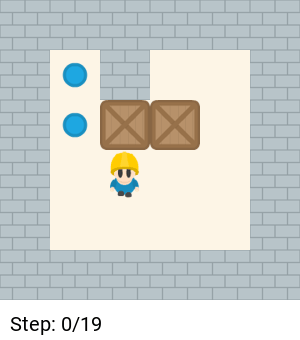

In [5]:
solver.generate_gif(filename='sokoban_solution_1.gif', fps=5)

### Example 2

In [6]:
solver = SokobanSolver([
    '11111111',
    '11001001',
    '11001001',
    '11002221',
    '10001001',
    '10001001',
    '11001111',
    '11001111',
    '11111111'
], (3, 6), [(2, 5), (3, 5), (4, 5)])

solution = solver.solve()

print("Solution Path:", solution)
print("Number of expanded nodes:", solver.expanded_nodes_count)
print("Number of visited nodes:", solver.visited_nodes_count)
print("Time used:", solver.time_used, 'seconds')

Solution Path: LLLULDDLDRURURRRDDLURULLLULDRRRRUULDRDLLLDDLDDRUUUDLLURURRRLLLDDRULURRLUULDDDLDRDRUULUR
Number of expanded nodes: 15817
Number of visited nodes: 15578
Time used: 0.4483299255371094 seconds


In [7]:
solver.solution_visualize()

Step: 0 Operation: 
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫⬜⬜🔳🟩👦🏻🟫
🟫⬜⬜⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫
Step: 1 Operation: L
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫⬜⬜🟩👦🏻🔳🟫
🟫⬜⬜⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 2 Operation: LL
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫⬜🟪👦🏻🔳🔳🟫
🟫⬜⬜⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 3 Operation: LLL
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫🟪👦🏻🔳🔳🔳🟫
🟫⬜⬜⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 4 Operation: LLLU
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜👦🏻🟫🟪⬜🟫
🟫🟫🟪⬜🔳🔳🔳🟫
🟫⬜⬜⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 5 Operation: LLLUL
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫👦🏻⬜🟫🟪⬜🟫
🟫🟫🟪⬜🔳🔳🔳🟫
🟫⬜⬜⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 6 Operation: LLLULD
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫👦🏻⬜🔳🔳🔳🟫
🟫⬜🟪⬜🟫🟪⬜🟫
🟫⬜⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 7 Operation: LLLULDD
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫⬜⬜🔳🔳🔳🟫
🟫⬜👦🏻⬜🟫🟪⬜🟫
🟫⬜🟪⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 8 Operation: LLLULDDL
🟫🟫🟫🟫🟫🟫🟫🟫
🟫🟫⬜⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟪⬜🟫
🟫🟫⬜⬜🔳🔳🔳🟫
🟫👦🏻⬜⬜🟫🟪⬜🟫
🟫⬜🟪⬜🟫⬜⬜🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫⬜⬜🟫🟫🟫🟫
🟫🟫🟫🟫🟫🟫🟫🟫

Step: 9 Operation: LLLULDDLD
🟫🟫🟫🟫🟫🟫🟫🟫



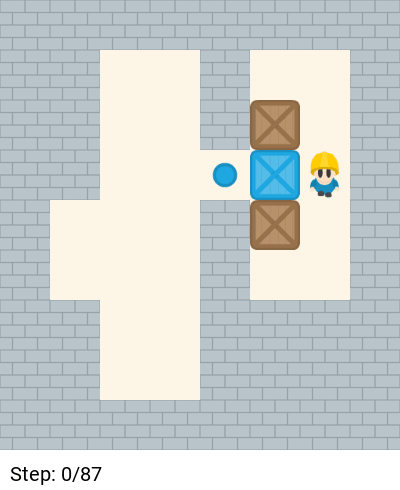

In [8]:
solver.generate_gif(filename='sokoban_solution_2.gif', fps=5)

### Example 3

In [9]:
solver = SokobanSolver([
    '1111111',
    '1000001',
    '1012101',
    '1000001',
    '1102201',
    '1101201',
    '1100001',
    '1111021',
    '1111111'
], (5, 2), [(3, 2), (3, 4), (4, 3), (4, 4), (6, 3)])

solution = solver.solve()

print("Solution Path:", solution)
print("Number of expanded nodes:", solver.expanded_nodes_count)
print("Number of visited nodes:", solver.visited_nodes_count)
print("Time used:", solver.time_used, 'seconds')

Solution Path: DRRURUULRDDLULRRUUULLDDUULLDDRDRULLUURRDDUURRDDDDLDDRUUUULLUULLDDRRUURRDDLDDRDDLULLUURURRDLRUUULLLLDDRDDDRRRUDLLLUUULUURRRRDDLDDRDLUUURUULLLLDDRRLDRLULUURRDDUURRDDLDDRUULLUULLDDRDRURRDLRDDDLUURUULLLDDDRLUUURRRDDDDLULLUUULUURRRRDDDDD
Number of expanded nodes: 118963
Number of visited nodes: 118955
Time used: 19.967598915100098 seconds


In [10]:
solver.solution_visualize()

Step: 0 Operation: 
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫👦🏻🟫🔳⬜🟫
🟫🟫⬜🟪⬜⬜🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫
Step: 1 Operation: D
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫👦🏻🟪⬜⬜🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 2 Operation: DR
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫⬜👦🏻🟪⬜🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 3 Operation: DRR
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫⬜⬜👦🏻🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 4 Operation: DRRU
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫👦🏻⬜🟫
🟫🟫⬜⬜⬜🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 5 Operation: DRRUR
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳👦🏻🟫
🟫🟫⬜⬜⬜🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 6 Operation: DRRURU
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪⬜🟫
🟫🟫⬜🟩🟩👦🏻🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫⬜⬜⬜🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 7 Operation: DRRURUU
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪⬜🟪👦🏻🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫⬜⬜⬜🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 8 Operation: DRRURUUL
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪🟪👦🏻⬜🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫⬜⬜⬜🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 9 Operation: DRRURUULR
🟫🟫🟫🟫🟫🟫🟫
🟫⬜⬜⬜⬜⬜🟫
🟫⬜🟫🔳🟫⬜🟫
🟫⬜🟪🟪⬜👦🏻🟫
🟫🟫⬜🟩🟩⬜🟫
🟫🟫⬜🟫🔳⬜🟫
🟫🟫⬜⬜⬜🟪🟫
🟫🟫🟫🟫⬜🔳🟫
🟫🟫🟫🟫🟫🟫🟫

Step: 10 Operati


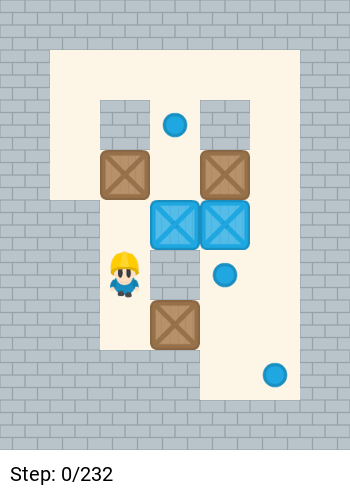

In [11]:
solver.generate_gif(filename='sokoban_solution_3.gif', fps=5)